<div>
<img src="https://notebooks.dtcglaciers.org/_images/ESA_logo.svg" width="160" align='right'/>
</div>

# CryoSat2 - model comparison at Vatnajökull ice cap, Iceland

This notebook was created at the beginning of the [DTC-Glaciers](https://dtcglaciers.org) project for illustration of the scientific challenges to be tackled. We compare the output from the Open Global Glacier Model (OGGM) v1.6.1 against EO And in-situ observations at Vatnajökull ice cap, Iceland.

In [1]:
from oggm import utils, workflow, tasks, DEFAULT_BASE_URL, cfg
import yaml
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_style("whitegrid")
sns.set_context("notebook")

In [2]:
# Where to find the test files on EODS
dtcf_url = 'https://cluster.klima.uni-bremen.de/~dtcg/test_files/case_study_regions/iceland/'

In [3]:
# OGGM parameters
cfg.initialize(logging_level='ERROR')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = True
cfg.PATHS['working_dir'] = utils.get_temp_dir('working_dir')

2026-01-10 15:18:14: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2026-01-10 15:18:14: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2026-01-10 15:18:14: oggm.cfg: Multiprocessing: using all available processors (N=8)
2026-01-10 15:18:14: oggm.cfg: Multiprocessing switched ON after user settings.
2026-01-10 15:18:14: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


## Load Vatnajökull RGI6 outlines

In [4]:
# RGI6 ids
with open(utils.file_downloader(dtcf_url + 'vatnajokull_rgi_ids.yml'), 'r') as yaml_file:
    rgi_ids = yaml.safe_load(yaml_file)['rgi_ids']

# Select the outlines from RGI6 file and convert to UTM
rgi_file = gpd.read_file(utils.get_rgi_region_file('06'))
rgi_file = rgi_file.loc[rgi_file.RGIId.isin(rgi_ids)].set_index('RGIId')
rgi_file = rgi_file.to_crs('EPSG:32628')

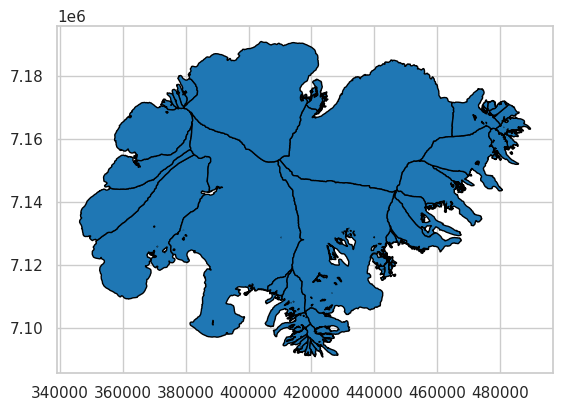

In [5]:
rgi_file.plot(ec='k');

## Fetch the standard global OGGM runs

In [6]:
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data?
    prepro_border=80  # how big of a map?
)

2026-01-10 15:18:15: oggm.workflow: init_glacier_directories from prepro level 4 on 118 glaciers.
2026-01-10 15:18:15: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 118 glaciers


## Re-run OGGM at monthly timestep and load data

In [7]:
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                             init_model_filesuffix='_spinup_historical',
                             init_model_yr=1979,
                             store_monthly_step=True,
                             ys=1979, ye=2020,
                             mb_elev_feedback='monthly',
                             output_filesuffix='_spinup_historical_monthly')

ds_monthly =  utils.compile_run_output(gdirs, input_filesuffix='_spinup_historical_monthly')

2026-01-10 15:18:19: oggm.workflow: Execute entity tasks [run_from_climate_data] on 118 glaciers
2026-01-10 15:18:20: oggm.core.flowline: AttributeError occurred during task run_from_climate_data_spinup_historical_monthly on RGI60-06.00387: 'Dataset' object has no attribute 'time'
2026-01-10 15:18:30: oggm.utils: Applying global task compile_run_output on 118 glaciers
2026-01-10 15:18:30: oggm.utils: Applying compile_run_output on 118 gdirs.


## Modelled mass change and comparison to calibration data 

### OGGM

In [8]:
years, months = utils.floatyear_to_date(ds_monthly.time)
df = pd.DataFrame(index=pd.to_datetime({'year': years, 'month': months, 'day': 1}))
df['OGGM_volume_m3'] = ds_monthly.sum(dim='rgi_id').volume.data

In [9]:
df['OGGM_mwe'] = (df['OGGM_volume_m3'] - df['OGGM_volume_m3'].loc['2000-01'].values) / (rgi_file.Area.sum() * 1e6) * 900 / 1000

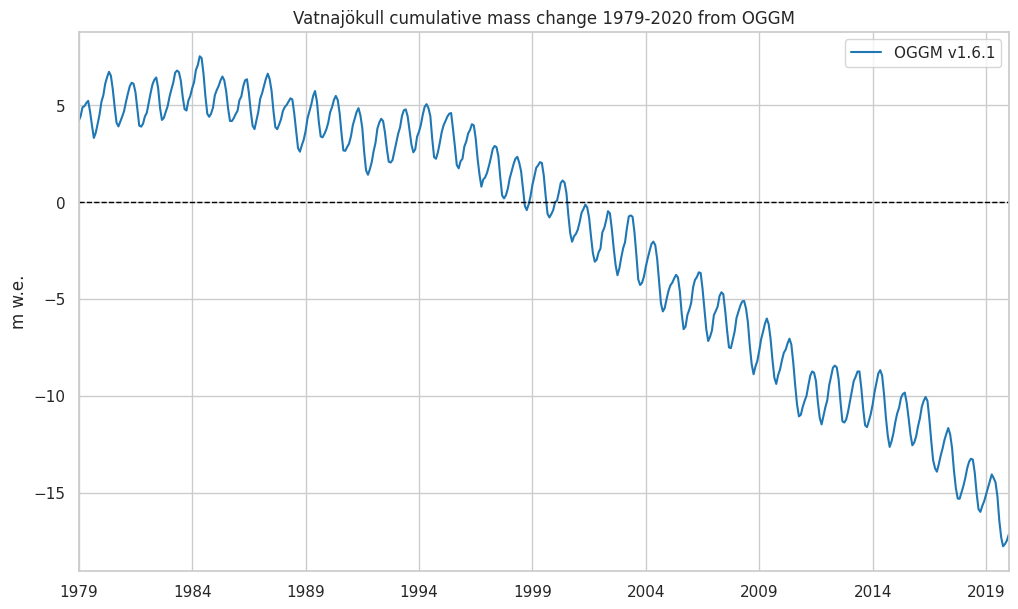

In [10]:
f, ax = plt.subplots(figsize=(12, 7))
df['OGGM_mwe'].plot(ax=ax, label='OGGM v1.6.1');
ax.axhline(0, linestyle="--", color="black", linewidth=1)
plt.ylabel('m w.e.'); plt.title('Vatnajökull cumulative mass change 1979-2020 from OGGM');
plt.legend();

### Hugonnet observations

In [11]:
ref_mb_df = utils.get_geodetic_mb_dataframe().loc[rgi_ids]
ref_mb_df = ref_mb_df.loc[ref_mb_df.period == '2000-01-01_2020-01-01']
hugonnet_20yrs = (ref_mb_df['area'] * ref_mb_df['dmdtda']).sum() / ref_mb_df['area'].sum() * 20
hugonnet_20yrs_err = (ref_mb_df['area'] * ref_mb_df['err_dmdtda']).sum() / ref_mb_df['area'].sum() * 20

/media/patrick/SD_CARD/mambaforge/envs/dtcg_env/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


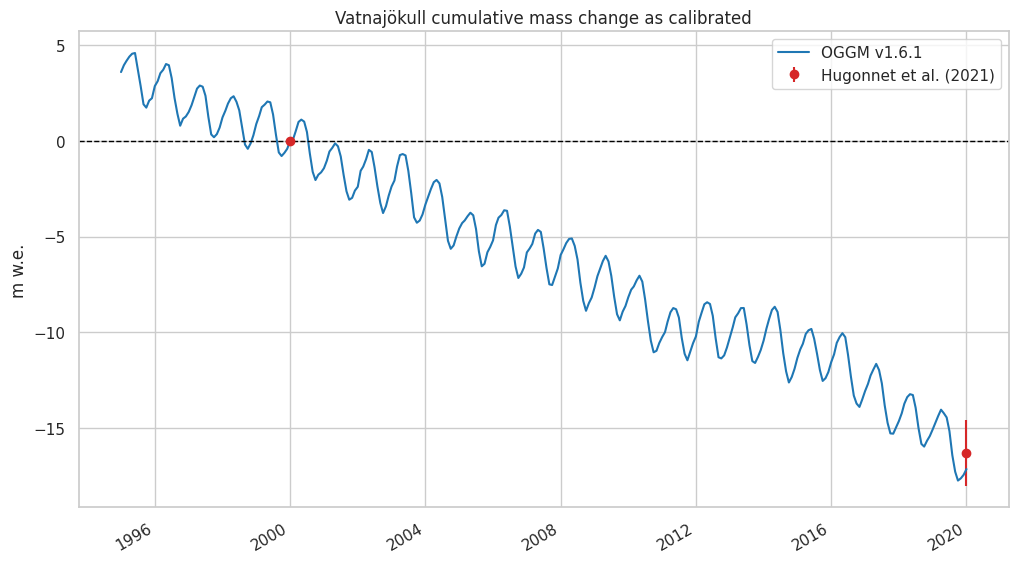

In [12]:
# Compute Hugonnet's mass balance estimates for the plot
p0 = df['OGGM_mwe'].loc['2000-01'].iloc[0]
p1 = hugonnet_20yrs + p0

f, ax = plt.subplots(figsize=(12, 7))
ptimes = df.loc[['2000-01', '2020-01']].index
ax.errorbar(x=ptimes, y=[p0, p1], yerr=[0, hugonnet_20yrs_err], fmt='o',
             color='C3', label='Hugonnet et al. (2021)')
df['OGGM_mwe'].loc['1995':].plot(ax=ax, label='OGGM v1.6.1');
ax.axhline(0, linestyle="--", color="black", linewidth=1)
plt.ylabel('m w.e.'); plt.title('Vatnajökull cumulative mass change as calibrated');
plt.legend();

## Elevation change comparison

### Load Cryosat-2 data

In [13]:
obs_file = utils.file_downloader(dtcf_url + 'averaged_grid.csv')
df_obs_elev = pd.read_csv(obs_file, index_col=1, parse_dates=True)
df_obs_elev = df_obs_elev['changes_t0']  # only keep average which is used for comparision

100% of   6.4 KiB |######################| Elapsed Time: 0:00:00 Time:  0:00:00


### Hugonnet et al

In [14]:
ref_mb_df = utils.get_geodetic_mb_dataframe().loc[rgi_ids]
ref_mb_df = ref_mb_df.loc[ref_mb_df.period == '2010-01-01_2020-01-01']
# Hugonnet uses 850
hugonnet_10yrs = (ref_mb_df['area'] * ref_mb_df['dmdtda']).sum() / ref_mb_df['area'].sum() * 10 * 1000 / 850
hugonnet_10yrs_err = (ref_mb_df['area'] * ref_mb_df['err_dmdtda']).sum() / ref_mb_df['area'].sum() * 10 * 1000 / 850

### WGMS

In [15]:
dfw = pd.read_csv(utils.file_downloader(dtcf_url + 'vatna_berthier.csv'), index_col=0)

dfwts = pd.DataFrame()

for y, d in dfw.iterrows():
    dfwts.loc[pd.Timestamp(year=y, month=4, day=1), 'MB'] = d.bw
    dfwts.loc[pd.Timestamp(year=y, month=10, day=1), 'MB'] = d.bs
    pass

dfwts['MB_m'] = dfwts['MB'] * 1000 / 850
dfwts['MB_m_cum'] = dfwts['MB_m'].cumsum()

100% of   2.7 KiB |######################| Elapsed Time: 0:00:00 Time:  0:00:00


### Compute modelled elevation change

In [16]:
# it is a bit unclear which basline was used by the observations
# from the meta_data: "average of the first 5 months (all data pre-2011)"
# baseline_volume = np.mean(volume_total.sel(time=slice(2011, 2011.5)))
# Her we just pick the first one in the obs timeseries
baseline_volume = df['OGGM_volume_m3'].loc['2010-09'].values

# divide by RGI area, which is the same area as used by the creation of the observation
rgi_area = np.sum([gdir.rgi_area_m2 for gdir in gdirs])

# finally the calculation of the modelled elevation change
# This assumes a density of 900 kg m2
df['OGGM_elev'] = (df['OGGM_volume_m3'] - baseline_volume) / rgi_area

### Plot elevation change observed vs. modelled

/media/patrick/SD_CARD/mambaforge/envs/dtcg_env/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


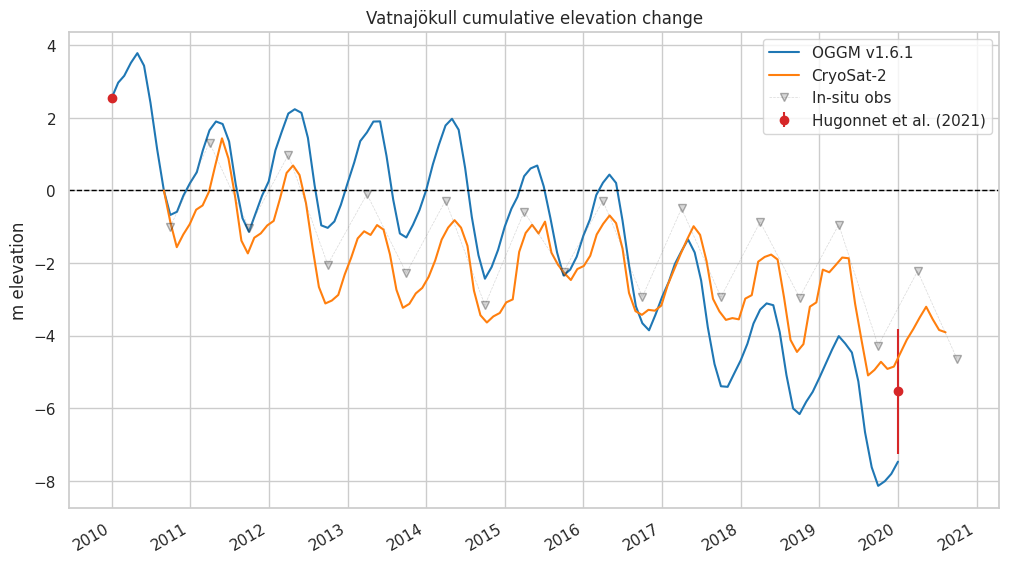

In [17]:
# Compute Hugonnet's mass balance estimates for the plot
p0 = df['OGGM_elev'].loc['2010-01'].iloc[0]
p1 = hugonnet_10yrs + p0

f, ax = plt.subplots(figsize=(12, 7))
ptimes = df.loc[['2010-01', '2020-01']].index
ax.errorbar(x=ptimes, y=[p0, p1], yerr=[0, hugonnet_20yrs_err], fmt='o',
             color='C3', label='Hugonnet et al. (2021)')
df['OGGM_elev'].loc['2010':].plot(ax=ax, label='OGGM v1.6.1');
df_obs_elev.plot(ax=ax, label='CryoSat-2')

wgts = (dfwts['MB_m_cum'] - dfwts['MB_m_cum'].loc['2010-10-01'] - 1).loc['2010-10-01':]
wgts.plot(ax=ax, linestyle='--', color='grey',  linewidth=0.5, alpha=0.3,
    marker='v', markersize=6, markerfacecolor='grey', markeredgecolor='k',
         label='In-situ obs');
ax.axhline(0, linestyle="--", color="black", linewidth=1)

# Set x-axis ticks to show every year
ax.xaxis.set_major_locator(mdates.YearLocator())  # One tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as "YYYY"

plt.xlabel(''); plt.ylabel('m elevation'); plt.title('Vatnajökull cumulative elevation change');
plt.legend();

## WGMS comparison

### Load WGMS data

In [18]:
fp_wgms = utils.file_downloader(dtcf_url + 'WGMS_MB-DTC-Glaciers.csv')
wgms_data = pd.read_csv(fp_wgms)

100% of 113.5 KiB |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Helper functions to access WGMS data

In [19]:
# conversions between wgms ids and rgi ids
fp_wgms_ids_conversion = utils.file_downloader(dtcf_url + 'glacier_id_lut.csv')
df_wgms_ids = pd.read_csv(fp_wgms_ids_conversion)

def get_wgms_from_rgi(rgi_id):
    if rgi_id in df_wgms_ids['RGI60_ID'].values:
        return df_wgms_ids[df_wgms_ids['RGI60_ID'] == rgi_id]['WGMS_ID'].item()
    else:
        return None

def get_rgi_from_wgms(wgms_id):
    if wgms_id in df_wgms_ids['WGMS_ID'].values:
        return df_wgms_ids[df_wgms_ids['WGMS_ID'] == wgms_id]['RGI60_ID'].item()
    else:
        return None

100% of  10.1 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:0400


In [20]:
def get_wgms_mb_observation(rgi_id):
    '''
    Returns (mb_DataFrame, Glacier name)
    '''
    wgms_id = get_wgms_from_rgi(rgi_id)

    # only not None if this glacier is a WGMS glacier
    if wgms_id:
        # check if we have some data
        if wgms_id in wgms_data['glacier_id'].values:
            wgms_glacier_data = wgms_data[wgms_data['glacier_id'] == wgms_id]
            df_wgms_glacier_data = pd.DataFrame(
                {'annual_balance': wgms_glacier_data['annual_balance'].values},
                index=wgms_glacier_data['year'].values,
            )
            return df_wgms_glacier_data, wgms_glacier_data['glacier_id.short_name'].values[0]

### Compute hydro year averages

In [21]:
# Here we need some code to work in hydro ye
df_annual = pd.DataFrame()
for y in range(1980, 2019):
    d0 = f'{y-1}-10-01'
    d1 = f'{y}-10-01'
    df_annual.loc[y, 'OGGM_mwe'] = df.loc[d1]['OGGM_mwe'] - df.loc[d0]['OGGM_mwe']

### Plot WGMS and modelled mb for all available glaciers

We commented the below because we have to sort out the data first - the above looks much better anyway.

In [22]:
# for gdir in gdirs:
#     wgms_mb = get_wgms_mb_observation(gdir.rgi_id)
#     if wgms_mb is not None:
#         fig, ax = plt.subplots(1, 1)
#         # add modelled smb
#         df_annual['OGGM_mwe'].plot(ax=ax, label='OGGM v1.6.1')
#         # add observation
#         wgms_mb[0]['annual_balance'].plot(ax=ax, marker='.',
#                                           label='Observations (WGMS)')
#         ax.set_title(f'{gdir.rgi_id}, {wgms_mb[1]}')
#         ax.set_xlabel(''); ax.set_ylabel('m w.e.');
#         ax.legend();
#         ax.set_xlim(1998, 2024);
#         plt.show()